# Airspace Risk Classification
# Copyright 2020, MIT Lincoln Laboratory
# SPDX-License-Identifier: BSD-2-Clause

## Introduction

This notebook walks through an example of classifying airspace risk for an entire state. The contents of this notebook are listed as follows:

- [Introduction](#Introduction)
- [Defining Variables](#DefiningVariables)
- [Data Loading](#DataLoading)
- [Running Code](#RunningCode)
    - [Main Function Call](#MainFunctionCall)
- [Visualization](#Visualization)

In [1]:
## Import python modules
import geopandas
import numpy as np
from p_tqdm import p_map
from util.AirspaceRiskClassification import *
import seaborn as sns
from matplotlib.colors import ListedColormap
import os


import matplotlib.pyplot as plt
%matplotlib inline

## <a name="DefiningVariables"></a> Defining Variables

The following variables will need to be defined to run the airspace risk classification. If running for a particular state or to change the lat/lon degree spacing, edit the cell below. A description of the variables are provided here for reference.

Variable | Description 
 :--- | :--- 
`path_to_emcore` | contains the path to the em-core directory. The code will automatically try to grab the path from the system environment variables. If it is not there, the user will be prompted to enter this information. 
`SPACING_deg` | (optional) This variable defines the spacing in degrees between latitude and longitude points when generating a uniform grid over a state (or polygon).
`STATE` | (optional) This variable defines the state to process when performing the airspace risk classification over an entire state.

In [2]:
try:
    path_to_emcore = os.environ['AEM_DIR_CORE']
except:
    print("PATH TO EMCORE NOT FOUND")
    path_to_emcore = input("Input path to emcore: (i.e ~/path/to/em-core)")
    
    

### This code is showing lon/lat grid spaced by 0.1 for demonstration
### Change to 0.02 for 1-1.2 nm grid
SPACING_deg = 0.1
STATE = 'VA'

PATH TO EMCORE NOT FOUND
Input path to emcore: (i.e ~/path/to/em-core)../../../em-core


## <a name="DataLoading"></a> Data Loading

Now that the variables are defined, we can load the required data for the airspace risk classification.

Data | Description | Download Location
 :--- | :--- | :---
FAA Airports | Contains airport geometry shapefiles. | Obtained through em-core installation.
FAA NASR | Contains airspace class information, along with their cooresponding geometries. | Obtained through em-core installation.
NE-Admin | Contains geometry shapefiles for all states in the US. | Obtained through em-core installation.
Census Block Group | Contains population density values and geometries for all US Census block groups. | Obtained through `scripts/setup.sh`.


In [3]:
## loading airport data

ap = geopandas.read_file('{}/data/FAA-Airports/e0bf64fc-79a3-49bc-9659-ea3f9fe875b52020328-1-157xrfq.2z5h.dbf'.format(path_to_emcore))

## airspace classes
airspace = geopandas.read_file('{}/data/FAA-NASR/Class_Airspace.dbf'.format(path_to_emcore))


## state shape file

# reading from the em-core repository
states_df = geopandas.read_file('{}/data/NE-Adminstrative/ne_10m_admin_1_states_provinces.dbf'.format(path_to_emcore))
states_df = states_df.loc[states_df.iso_a2 == 'US']  ## only want to obtain US states
states_df.loc[:,'iso_3166_2'] = states_df.loc[:,'iso_3166_2'].apply(lambda x: x[3:]) ## slicing off 'US' from 'US-state'
states_df.loc[:,'fips'] = states_df.loc[:,'fips'].apply(lambda x: x[2:]) ## slicing off 'US' from 'USfips'

## preprocessed census block group shape file
bg_df = geopandas.read_file('data/blockgroup/processed/BG.dbf')




class Data:
    def __init__(self,bg_df,airspace,ap,states_df):
        self.bg_df = bg_df
        self.airspace = airspace
        self.ap = ap
        self.states_df = states_df

data = Data(bg_df,airspace,ap,states_df)       

# <a name="RunningCode"></a> Classify Coordinates

We are now ready to begin running the airspace risk classifcation. To do this we first define a global variable below called `point_in`. This is needed to make sure that all lat/lon points are within the selected state and to trim off any lat/lons that are not within the state. If you are not running for a particular state, you do not need this function.

In [4]:
### Need this function here for global "poly" variable

def point_in(point):
    return point.within(poly)

In [5]:
# Calculating Low_Risk airspace for the state of Virginia


# State selected as Virginia. Now grabbing the geometry from the data above.
state = states_df.loc[states_df.iso_3166_2 == STATE]
poly,points = generate_grid_in_polygon(SPACING_deg, state)  # generating lon,lat meshgrid

# lon/lat points corresponding to VA.
lonlats = np.array(getLatLons(points[0],points[1])) # converting the meshgrid to a list of lon/lat points.


# This is an array of shapely geometry points
points = np.array([Point(x,y) for x,y in lonlats],dtype=object)


# The points may not all be within VA due to the linearity of numpy meshgrid. 
# We now can trim off the points that do not fall withing the state boundary
print('Checking to make sure points are withing the state boundary...')
ind2keep = np.array(p_map(point_in,points))


## Keeping lonlats/points that are withing the selected STATE
lonlats = lonlats[ind2keep == 1] ## Note: if ind2keep is a BOOLEAN array then " == 1" is optional
points = points[ind2keep == 1]

Checking to make sure points are withing the state boundary...


### <a name="MainFunctionCall"></a> Main Function Call

The code block below is the main function call to determine the airspace risk class of the input lon/lat points. Note that this function also accepts altitude in AGL. If it is not specified it is set to 500 AGL for all input lon/lat points. Internet connection is required to run the code below. In the event it fails, it may be due to an internet connectivity problem. Often times, rerunning the code cell resolves the problem.

In [6]:
df,lr_df = RiskClassification(lonlats,data,points=points)

Step 1: Population Density Check
------------------------------------------------------------------------------
> Beginning check on 1039 points...
 
> Finished! Time: 15s | Total Time: 15s
> 230 points violated population density criteria
------------------------------------------------------------------------------
------------------------------------------------------------------------------
 
Step 2: Distance to Closest Aerodrome
------------------------------------------------------------------------------
> Beginning check on 809 points...
 


/Users/ma28086/anaconda3/envs/air5/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ma28086/anaconda3/envs/air5/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s



> Finished! Time: 0s | Total Time: 16s
> 397 points violated distance to aerodrome criteria
------------------------------------------------------------------------------
------------------------------------------------------------------------------
 
Step 3: Uncontrolled Airspace
------------------------------------------------------------------------------
> Beginning check on 412 points...
 



> Finished! Time: 12s | Total Time: 28s
> 0 points violated airspace class
------------------------------------------------------------------------------
------------------------------------------------------------------------------
Step 1: Population Density Check
------------------------------------------------------------------------------
> Beginning check on 627 points...
 
> Finished! Time: 1s | Total Time: 1s
> 0 points violated population density criteria
------------------------------------------------------------------------------
------------------------------------------------------------------------------
 
Step 2: Distance to Closest Aerodrome
------------------------------------------------------------------------------
> Beginning check on 627 points...
 



> Finished! Time: 1s | Total Time: 3s
> 73 points violated distance to aerodrome criteria
------------------------------------------------------------------------------
------------------------------------------------------------------------------
 
Step 3: Uncontrolled Airspace
------------------------------------------------------------------------------
> Beginning check on 554 points...
 



> Finished! Time: 80s | Total Time: 83s
------------------------------------------------------------------------------
------------------------------------------------------------------------------


# Visualization

We can now vidualize the results of the airspace risk classification. The code blocks below show how to display the results and save them.

In [7]:
three_colors = ["#a61b0c","#1f60b5", "#0da329"] # 3 colors

two_colors_cmap = ListedColormap(sns.color_palette(three_colors[:2]).as_hex())
three_colors_cmap = ListedColormap(sns.color_palette(three_colors).as_hex())

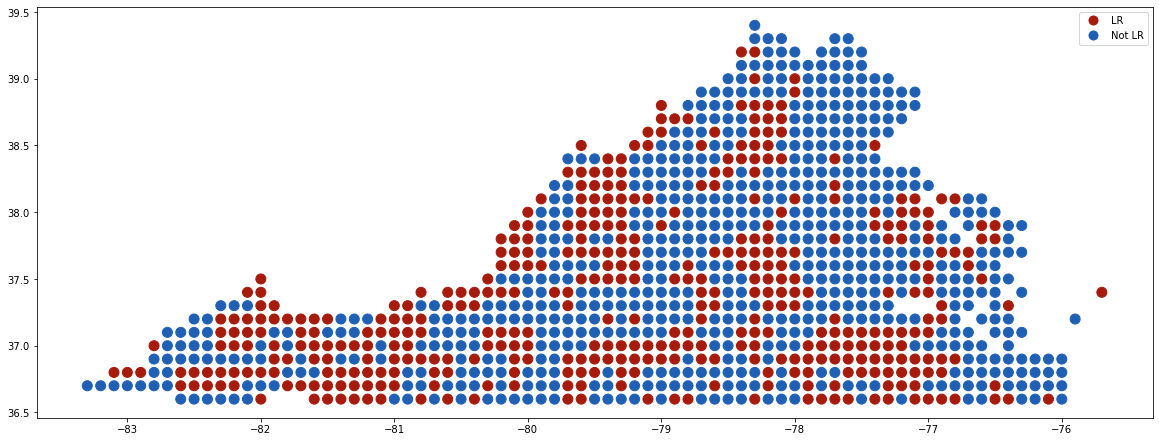

In [8]:
## Markersize should be tuned depending on the SPACING variable. It is large here due to large SPACING


ax_lr = lr_df.plot(column='Type',figsize=(20,16),cmap=two_colors_cmap,legend=True,markersize=100)

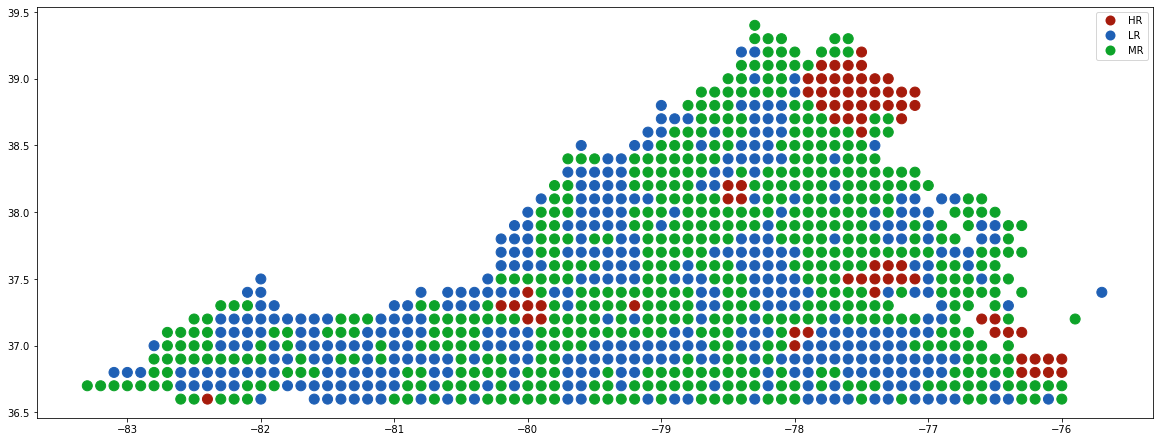

In [9]:
## Markersize should be tuned depending on the SPACING variable. It is large here due to large SPACING


ax_df = df.plot(column='Type',figsize=(20,16),cmap=three_colors_cmap,legend=True,markersize=100)

### Saving Figure

In [10]:
## To save the figure above as a .png file to the output directory you can run this command:

ax_df.figure.savefig("output/VA.png")